In [1]:
# 匯入/處理/裁切圖片 getting numpy arrays of pixel values of images.
import os # use directory & join path
from pathlib import Path # 去掉副檔名
import cv2 #opencv library read img operations                  
import numpy as np # array operations
from decimal import Decimal # 精準小數點四捨五路
import math
 
# data visualisation and manipulation
import matplotlib.pyplot as plt #show img and table
import pandas as pd # 匯出 csv
from PIL import Image

In [2]:
def transferRGBChannal(src_rgb, src_mean_R, src_mean_G, src_mean_B, src_std_R, src_std_G, src_std_B, tar_mean_R, tar_mean_G, tar_mean_B, tar_std_R, tar_std_G, tar_std_B):
    
    result_rgb = src_rgb

    for i in range(len(src_rgb)):
        for j in range(len(src_rgb[0])):

            result_rgb[i][j][0] = (src_rgb[i][j][0] - src_mean_R) * (tar_std_R / src_std_R) + tar_mean_R
            result_rgb[i][j][1] = (src_rgb[i][j][1] - src_mean_G) * (tar_std_G / src_std_G) + tar_mean_G
            result_rgb[i][j][2] = (src_rgb[i][j][2] - src_mean_B) * (tar_std_B / src_std_B) + tar_mean_B
            
            # 超過邊界拉回在邊界上
            if(result_rgb[i][j][0] < 0 ): result_rgb[i][j][0] = 0
            elif(result_rgb[i][j][0] > 255 ): result_rgb[i][j][0] = 255
                
            if(result_rgb[i][j][1] < 0 ): result_rgb[i][j][1] = 0
            elif(result_rgb[i][j][1] > 255 ): result_rgb[i][j][1] = 255
                
            if(result_rgb[i][j][2] < 0 ): result_rgb[i][j][2] = 0
            elif(result_rgb[i][j][2] > 255 ): result_rgb[i][j][2] = 255
                
    return result_rgb

In [3]:
def show_histogram(typeStr, img_rgb, img_name):

    plt.figure(figsize=(20,10))

    # 印出圖片
    plt.subplot(231)
    #img = image.load_img(img_path)
    plt.imshow(img_rgb)
    if(typeStr == 's'):
        plt.title("source Name : " + img_name)
    elif(typeStr == 't'):
        plt.title("target Name : " + img_name)
    elif(typeStr == 'c'):
        plt.title("coltra Name : " + img_name)

    # 繪 RGB 三通道
    color = ('r', 'g', 'b')
    for i, col in enumerate(color):

        plt.subplot(232)
        # cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.title("RGB channel histogram")
        plt.xlabel("RBB value")
        plt.ylabel("frequent")
        plt.xlim([0, 256])

    hist_R = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_G = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_B = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])
     
    #繪個別通道值方圖
    # red channel
    plt.subplot(234)
    plt.bar(range(1,257), hist_R.ravel(), color='r')
    plt.title("red channel histogram")
    plt.xlabel("R value")
    plt.ylabel("frequent")

    # green channel
    plt.subplot(235)
    plt.bar(range(1,257), hist_G.ravel(), color='g')
    plt.title("green channel histogram")
    plt.xlabel("G value")
    plt.ylabel("frequent")

    plt.subplot(236)
    plt.bar(range(1,257), hist_B.ravel(), color='b')
    plt.title("blue channel histogram")
    plt.xlabel("B value")
    plt.ylabel("frequent")
    
    # 計算 各通道 平均 & 標準差
    sum_R = 0.0
    sum_G = 0.0
    sum_B = 0.0
    for i in range(256):
        sum_R += int(hist_R[i]) * i
        sum_G += int(hist_G[i]) * i
        sum_B += int(hist_B[i]) * i
    
    # hist_R.sum() 為圖片總像數
    pixels = hist_R.sum()
    avg_R = sum_R / pixels
    avg_G = sum_G / pixels
    avg_B = sum_B / pixels
    
    # 四捨五入
    avg_R = Decimal(avg_R).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    avg_G = Decimal(avg_G).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    avg_B = Decimal(avg_B).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    
    sum_stdR = 0.0
    sum_stdG = 0.0
    sum_stdB = 0.0
    for x in range(256):
        sum_stdR += math.pow(x-avg_R,2) * hist_R[x]
        sum_stdG += math.pow(x-avg_G,2) * hist_G[x]
        sum_stdB += math.pow(x-avg_B,2) * hist_B[x]
        
    stdev_R = math.sqrt(sum_stdR / pixels)
    stdev_G = math.sqrt(sum_stdG / pixels)
    stdev_B = math.sqrt(sum_stdB / pixels)
    
    # 四捨五入
    stdev_R = Decimal(stdev_R).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    stdev_G = Decimal(stdev_G).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    stdev_B = Decimal(stdev_B).quantize(Decimal("0.01"), rounding = "ROUND_HALF_UP")
    
    # 印出平均與標準差
    if(typeStr == 's'):
        print("\n來源圖檔名: ", img_name)
    elif(typeStr == 't'):
        print("\n目標圖檔名: ", img_name)
    elif(typeStr == 'c'):
        print("\n顏色轉換結果圖檔名: ", img_name)

    print("R_channel 平均: ", avg_R)
    print("R_channel 標準差: ", stdev_R)
    print("\nG_channel 平均: ", avg_G)
    print("G_channel 標準差: ", stdev_G)
    print("\nB_channel 平均: ", avg_B)
    print("B_channel 標準差: ", stdev_B)
    
    return  avg_R, avg_G, avg_B, stdev_R, stdev_G, stdev_B, hist_R, hist_G, hist_B


In [4]:
def outputMeanStdCsv(img_name, r_avg, g_avg, b_avg, r_stdev, g_stdev, b_stdev):
    
    MeanStd = [[r_avg , g_avg, b_avg],[r_stdev, g_stdev, b_stdev]]
    MeanStd_table = pd.DataFrame(MeanStd)

    col_name = ['red','green','blue']
    row_name = ['Average','Standard Deviation']
    MeanStd_table.columns = col_name
    MeanStd_table.index = row_name
    #print(MeanStd_table)
    
    # 匯出 answer table 成 csv 檔
    MeanStd_table.to_csv('result/'+ img_name + '-mean-std.csv')

In [5]:
def outputHistogramCsv(img_name, hist_R, hist_G, hist_B):
    # hisRGB table array
    hisRGB = []
   
    for i in range(len(hist_R)):
        hisRGB.extend([hist_R[i], hist_G[i], hist_B[i]])
        
    hisRGB = np.array(hisRGB)
    hisRGB = hisRGB.reshape(-1,3)
    
    hisRGB_table = pd.DataFrame(hisRGB)
    
    col_name = ['Red_his','Green_his','Blue_his']
    hisRGB_table.columns = col_name
    #print(hisRGB_table)
    
    # 匯出 answer table 成 csv 檔
    hisRGB_table.to_csv('result/'+ img_name + '-his.csv')
    

In [6]:
def resize(img_rgb):
    
    width = len(img_rgb[0])   # 寬度
    height = len(img_rgb)  # 高度

    # resize src
    if(width > 1024 or height > 1024):
        if(width > height):
            widthSize = 1024
            heightSize = int(1024 * height / width)
        else:
            heightSize = 1024
            widthSize = int(1024 * width / height)
        #print("widthSize=",widthSize,"heightSize=",heightSize)
        img_rgb = cv2.resize(img_rgb, (widthSize, heightSize))
        
    return img_rgb


來源圖檔名:  01_kodim08.png
R_channel 平均:  127.96
R_channel 標準差:  63.74

G_channel 平均:  121.08
G_channel 標準差:  65.29

B_channel 平均:  116.00
B_channel 標準差:  57.39

目標圖檔名:  01_kodim07.png
R_channel 平均:  117.56
R_channel 標準差:  41.08

G_channel 平均:  110.72
G_channel 標準差:  37.61

B_channel 平均:  85.37
B_channel 標準差:  39.25

顏色轉換結果圖檔名:  01_kodim08_kodim07.png
R_channel 平均:  117.06
R_channel 標準差:  41.08

G_channel 平均:  110.21
G_channel 標準差:  37.60

B_channel 平均:  84.87
B_channel 標準差:  39.25

來源圖檔名:  02_4.2.06.tiff
R_channel 平均:  131.01
R_channel 標準差:  42.80

G_channel 平均:  124.30
G_channel 標準差:  77.64

B_channel 平均:  114.89
B_channel 標準差:  76.84

目標圖檔名:  02_kodim12.png
R_channel 平均:  161.57
R_channel 標準差:  40.38

G_channel 平均:  167.00
G_channel 標準差:  50.12

B_channel 平均:  137.86
B_channel 標準差:  46.17

顏色轉換結果圖檔名:  02_4.2.06_kodim12.png
R_channel 平均:  161.05
R_channel 標準差:  40.37

G_channel 平均:  166.49
G_channel 標準差:  50.12

B_channel 平均:  137.38
B_channel 標準差:  46.17

來源圖檔名:  03_waterfall-kanchanab

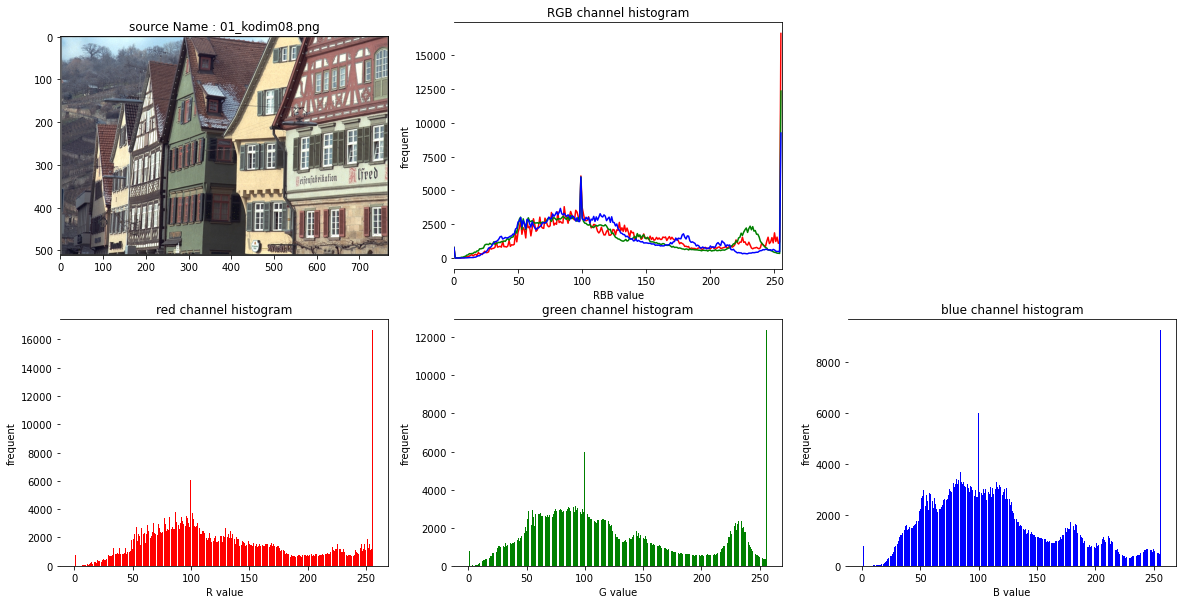

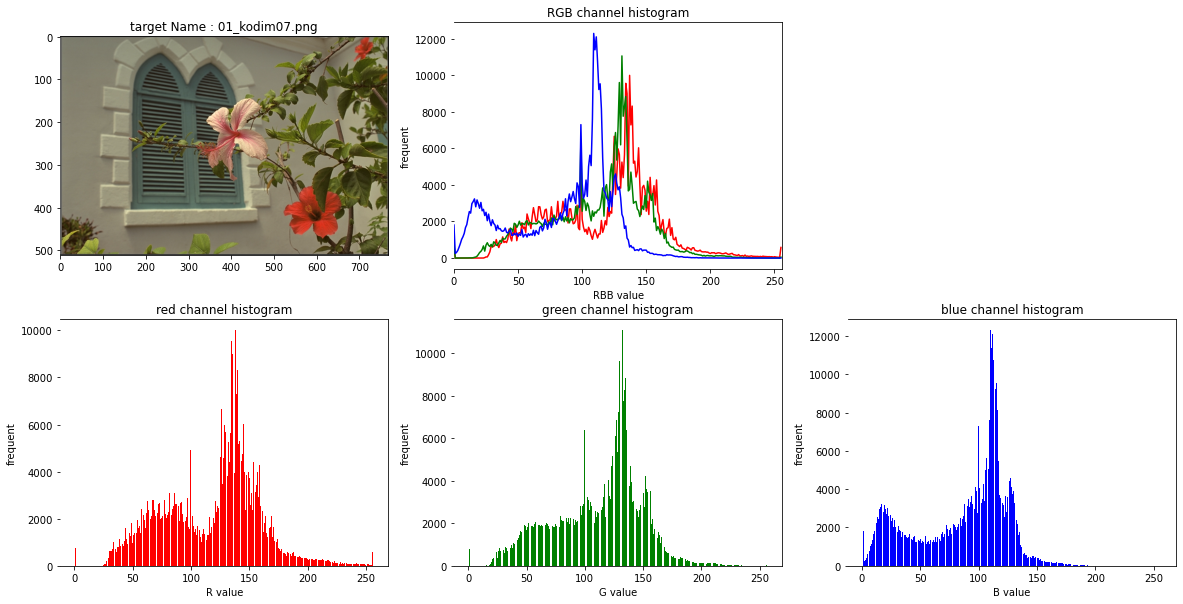

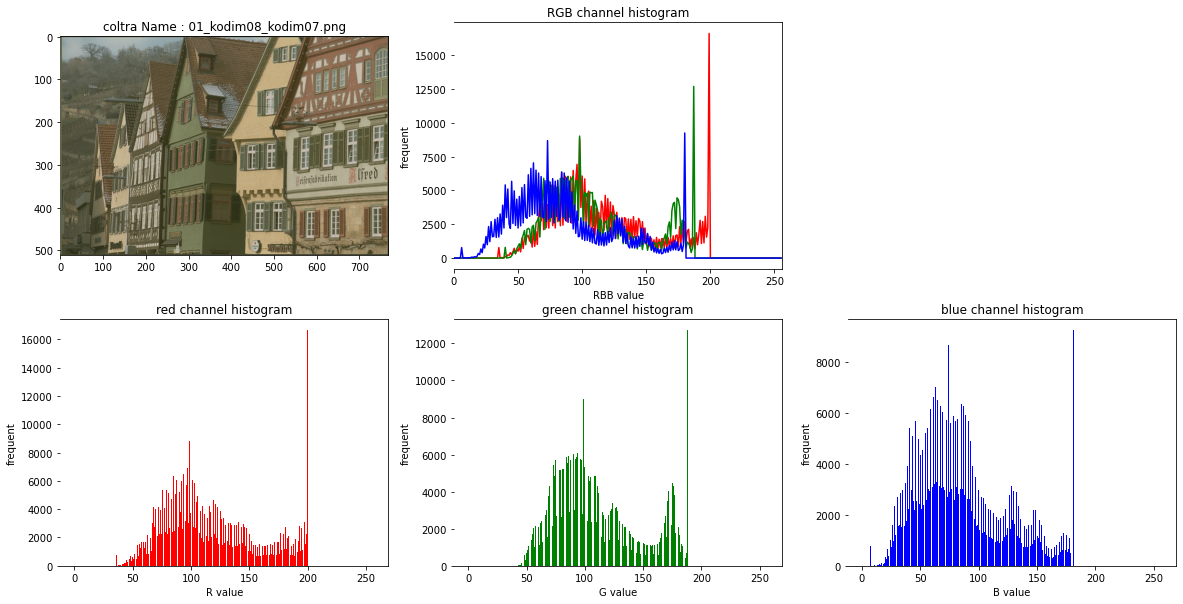

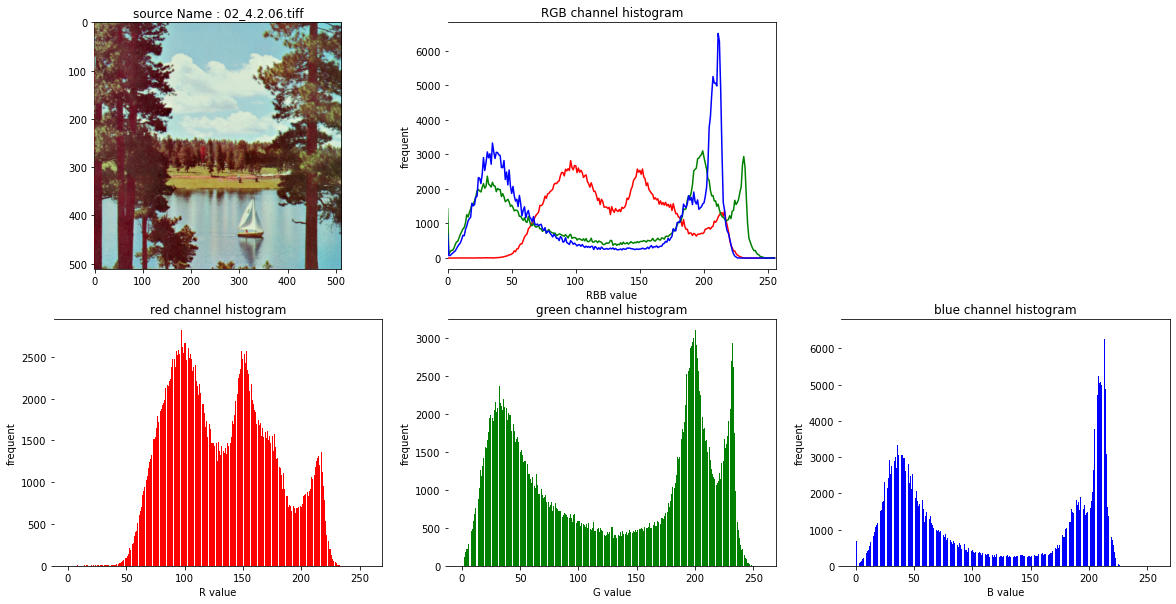

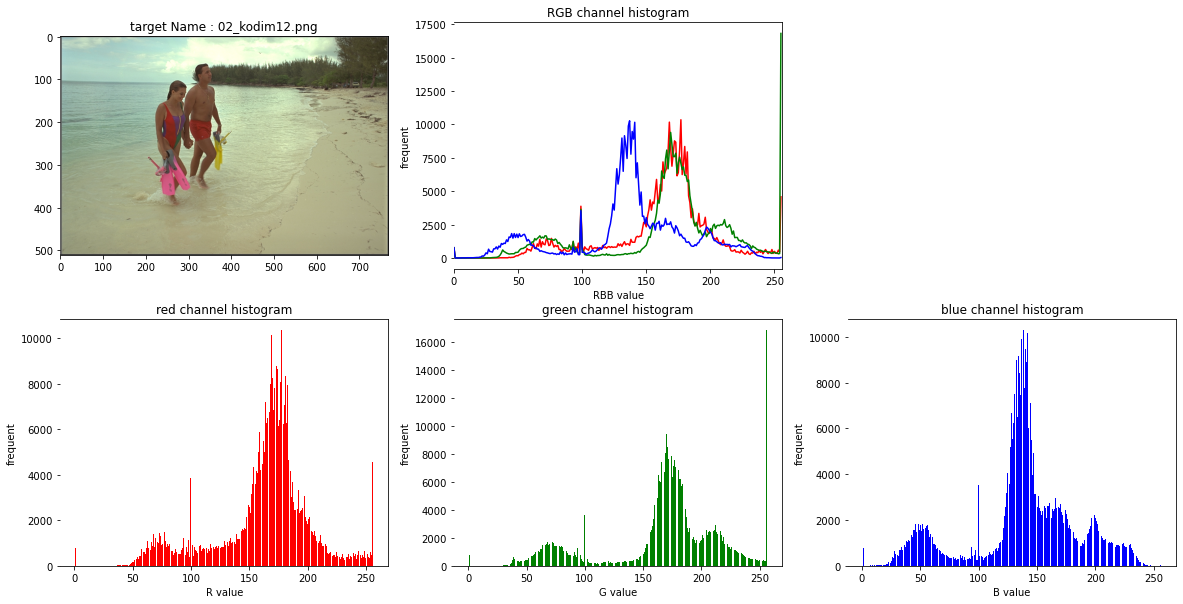

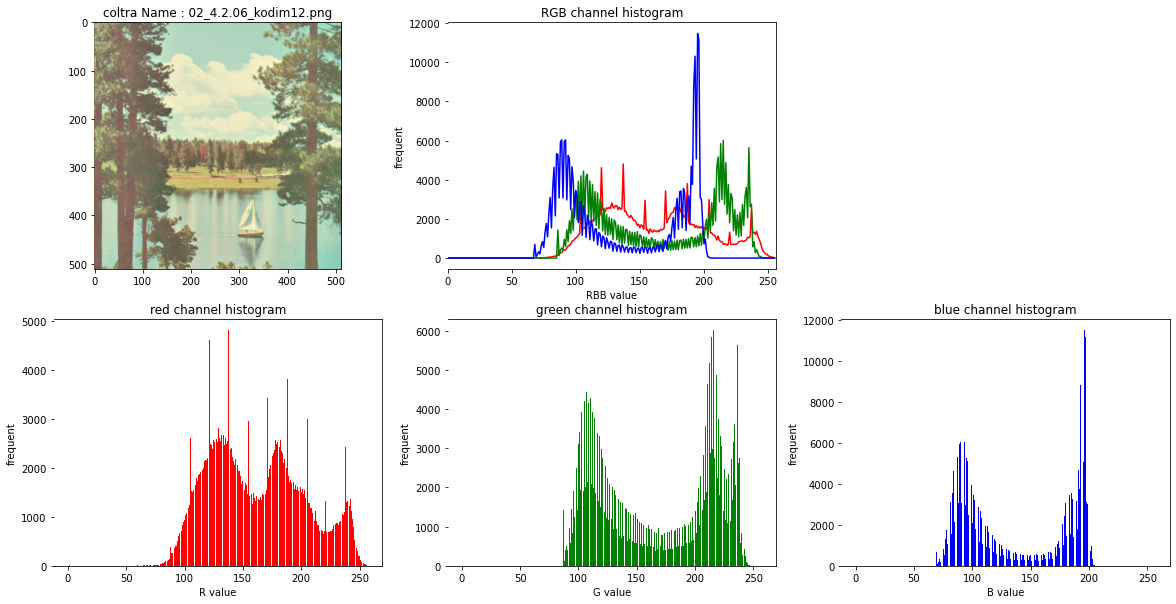

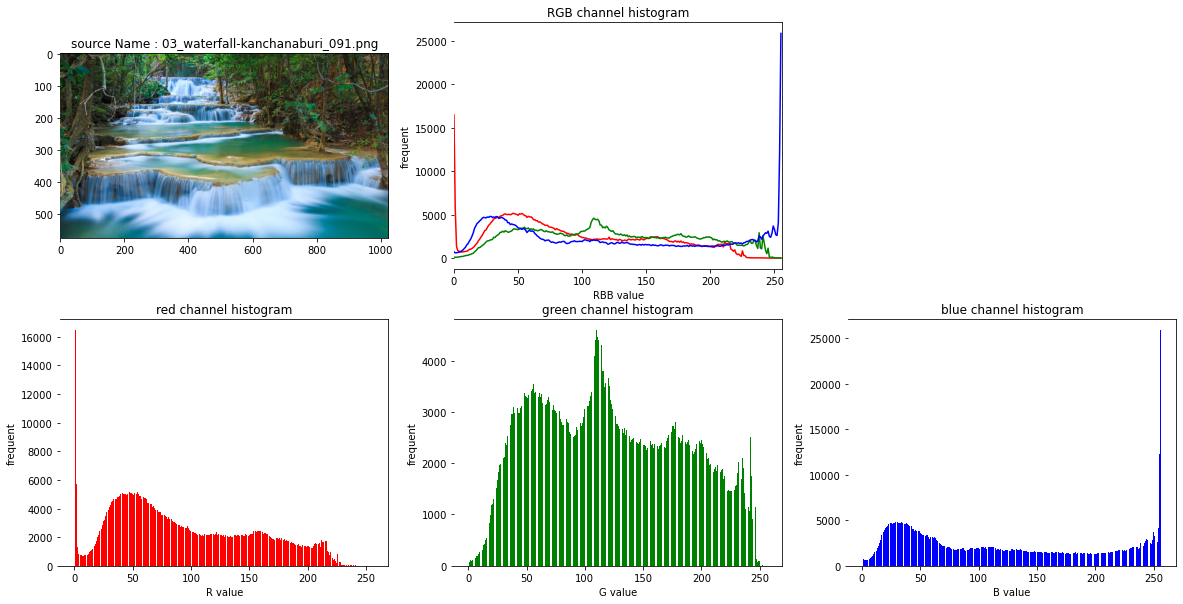

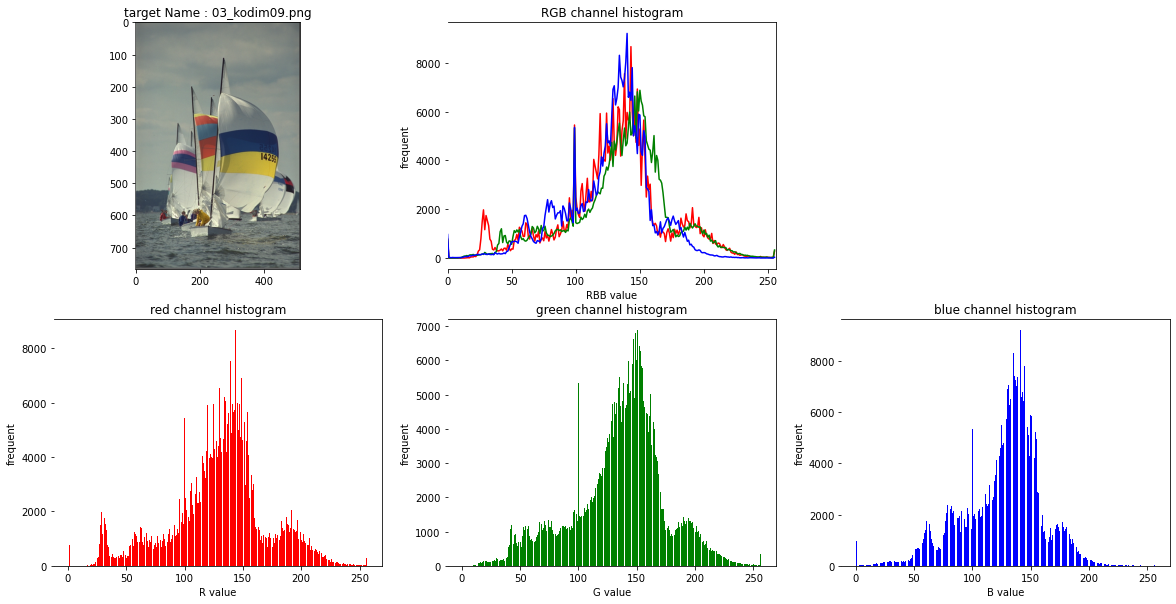

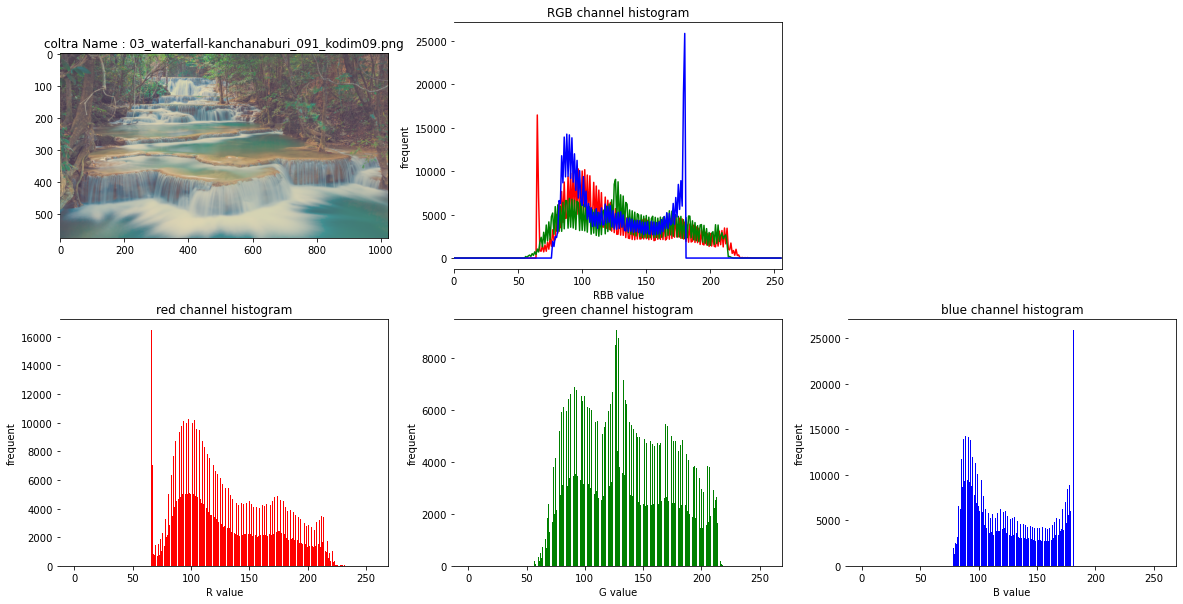

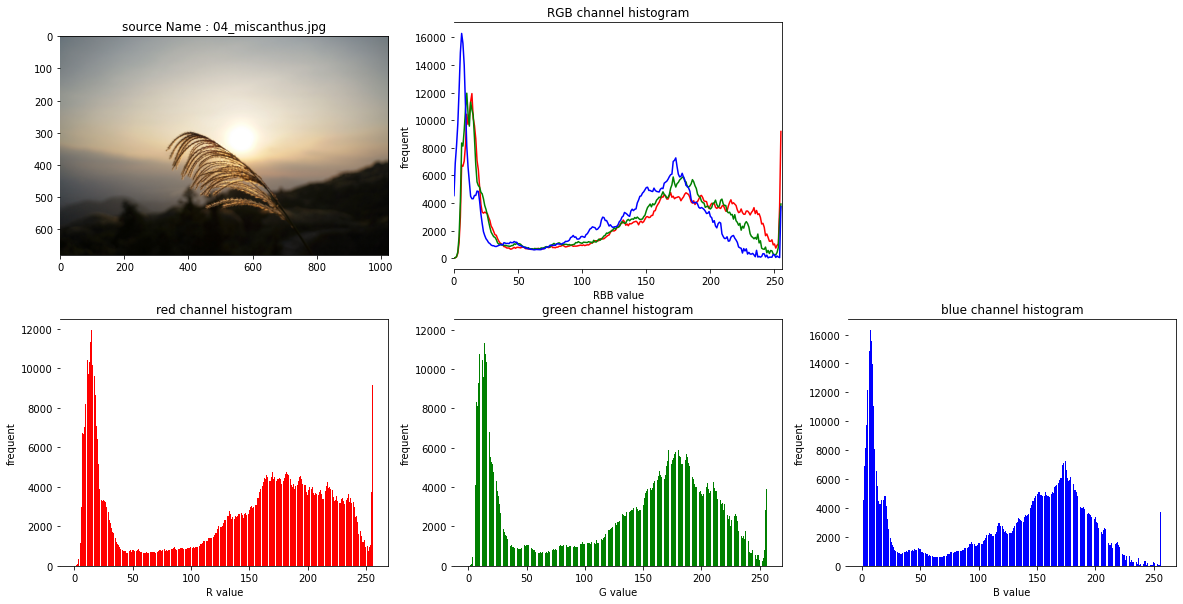

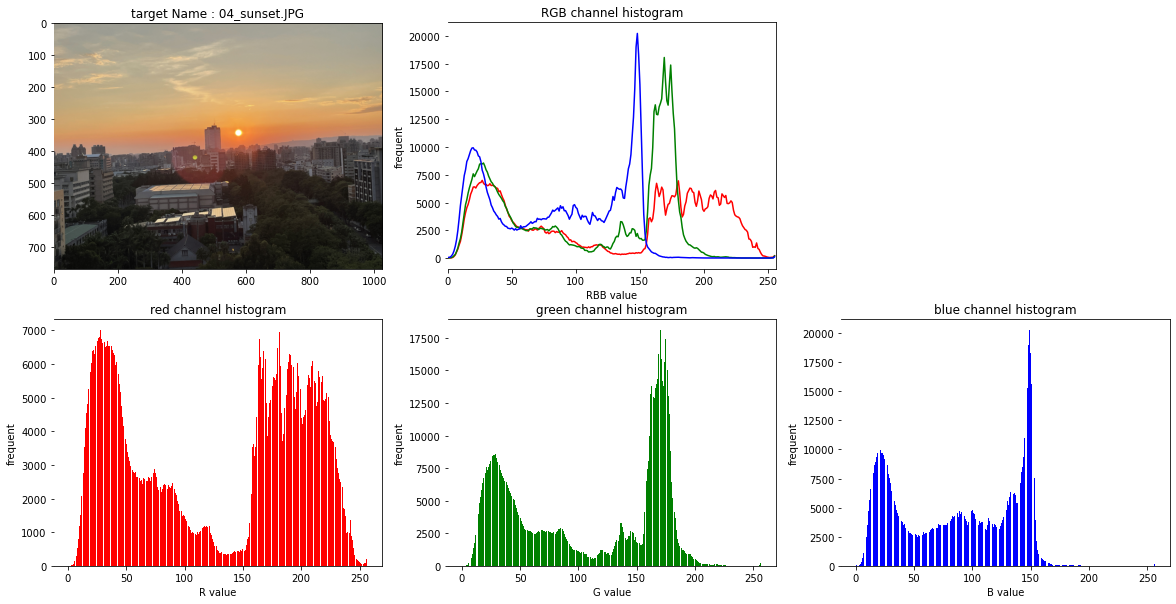

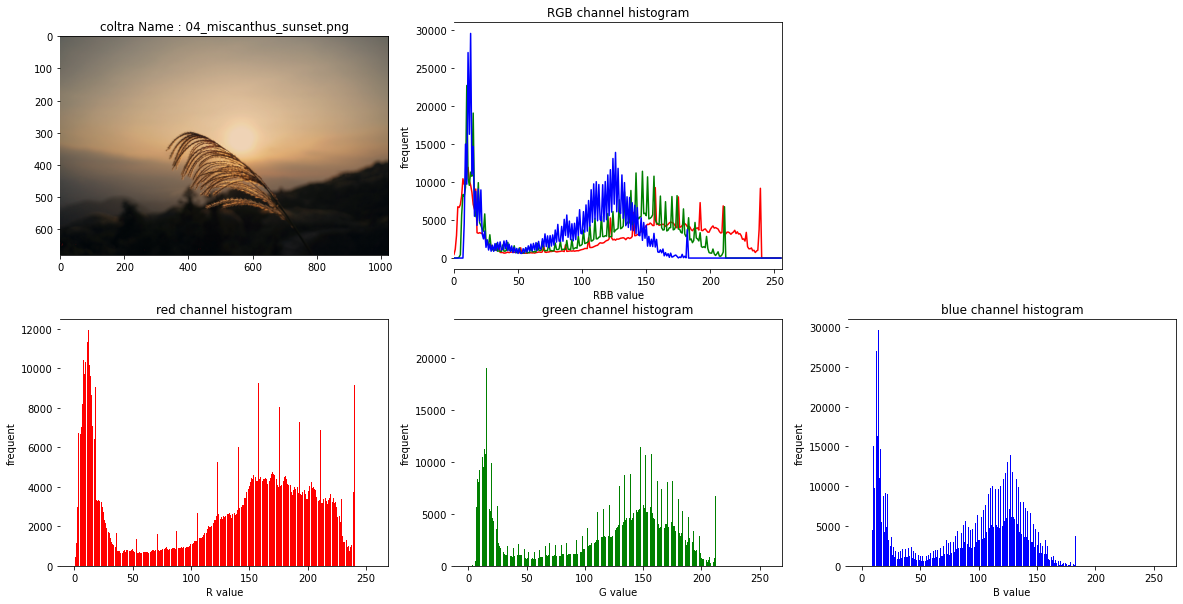

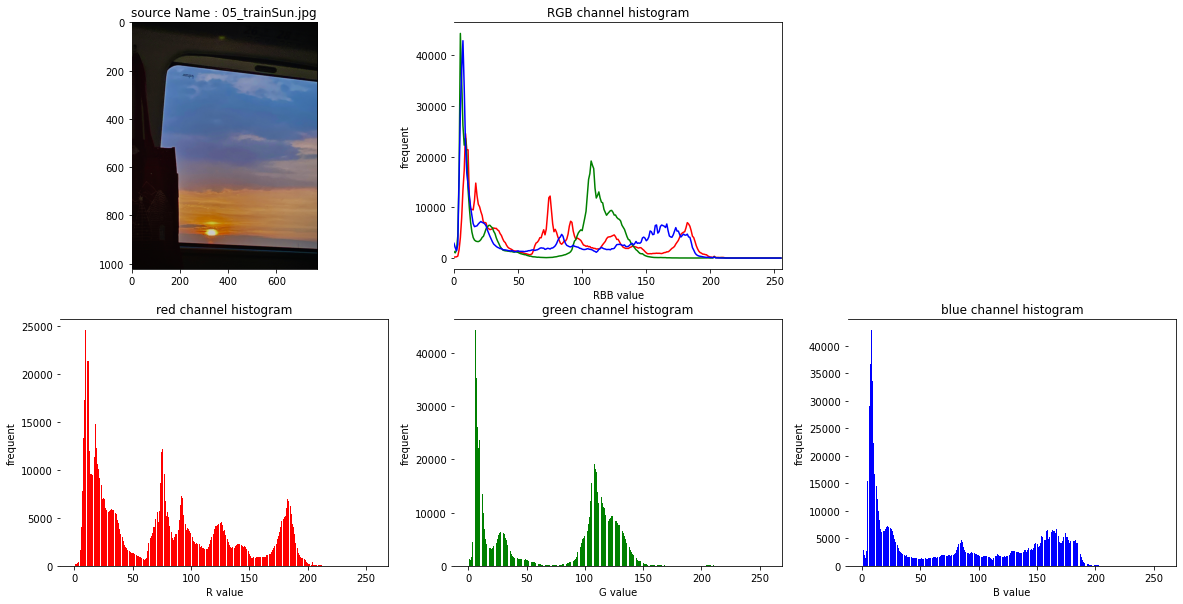

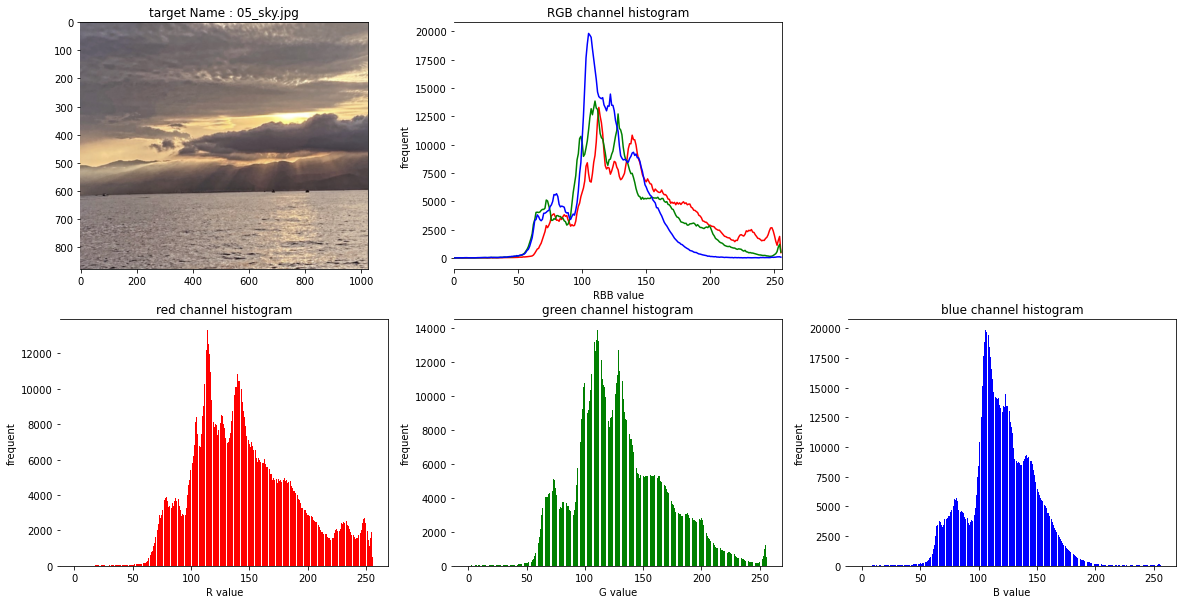

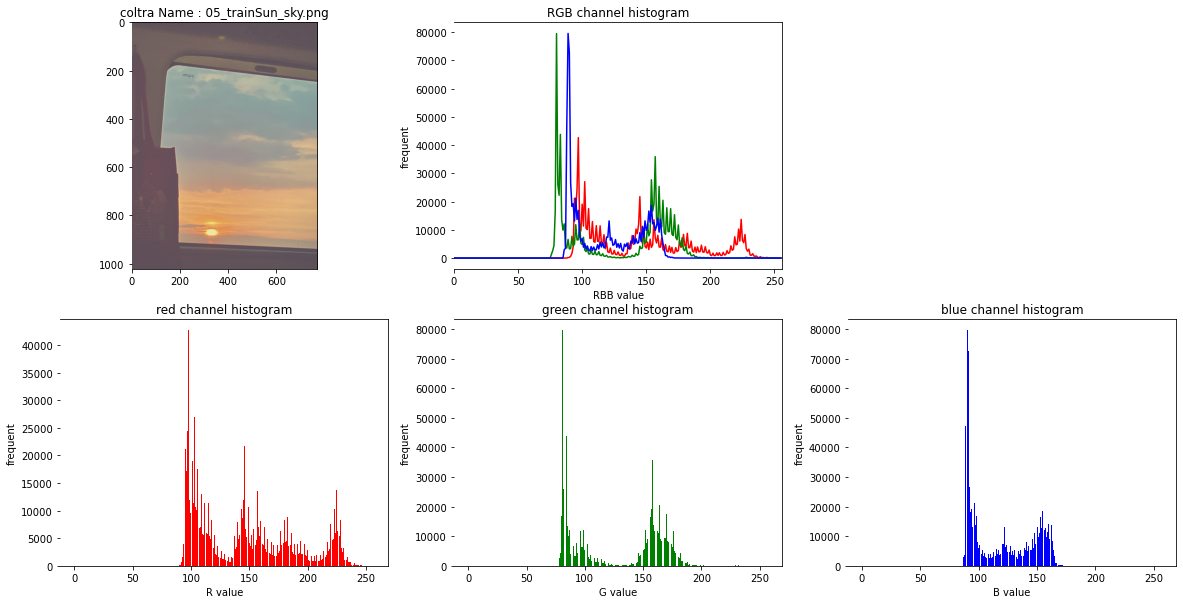

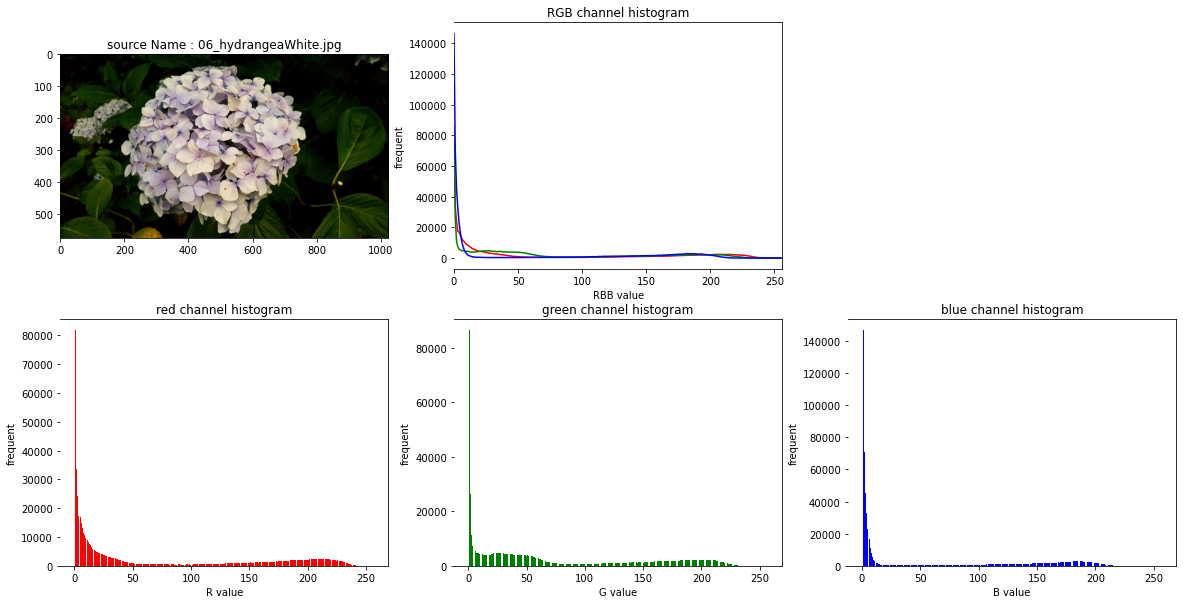

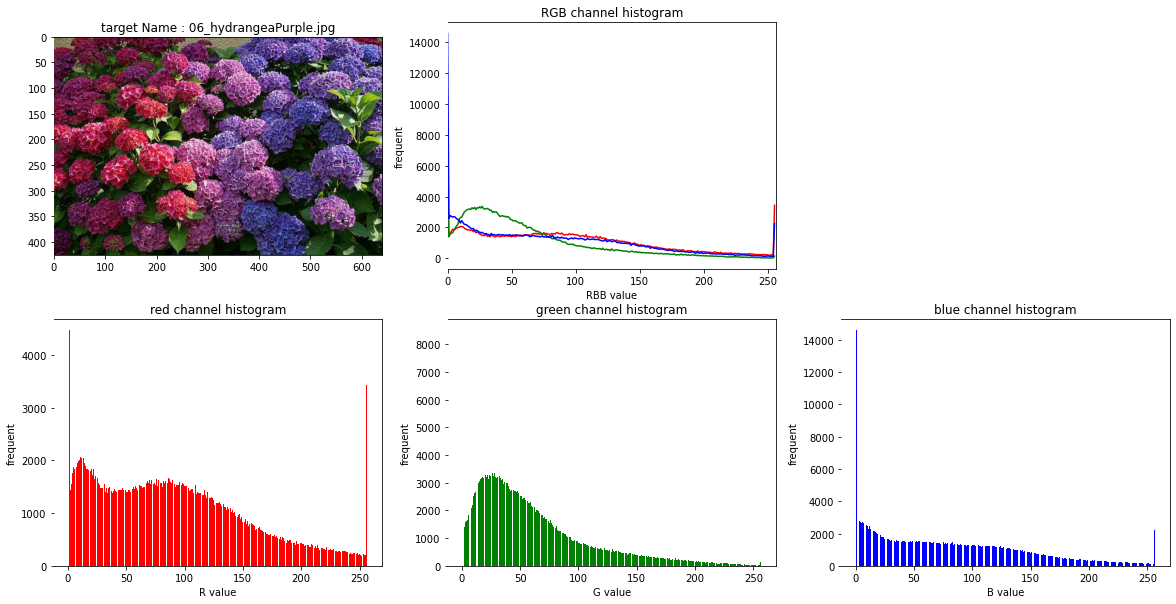

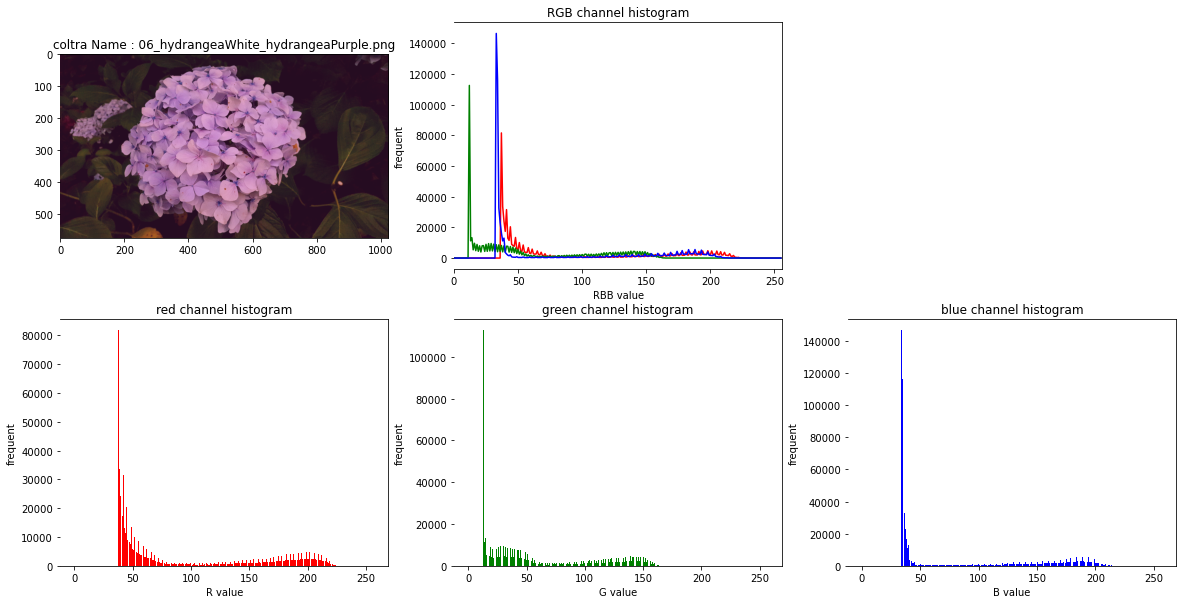

In [7]:
# 印出所有圖片
DATASRC = 'source/'
DATATRG = 'target/'

# 抓目錄下所有圖檔檔名
src_name = os.listdir(DATASRC)
tar_name = os.listdir(DATATRG)
# print(src_name)
# print(tar_name)

for i in range (len(src_name)):
        
    # 圖片完整路徑
    src_path = DATASRC + src_name[i]
    tar_path = DATATRG + tar_name[i]
    
    # convert img to array 以彩色格式讀取(三維)
    src_bgr = cv2.imread(src_path ,cv2.IMREAD_COLOR)
    tar_bgr = cv2.imread(tar_path ,cv2.IMREAD_COLOR)
    
    # 原為 BGR 轉為 RGB
    src_rgb = cv2.cvtColor(src_bgr,cv2.COLOR_BGR2RGB)
    tar_rgb = cv2.cvtColor(tar_bgr,cv2.COLOR_BGR2RGB)
    
    # 超過 1024像素 resize
    src_rgb = resize(src_rgb)
    tar_rgb = resize(tar_rgb)

    # 畫值方圖
    src_mean_R, src_mean_G, src_mean_B, src_std_R, src_std_G, src_std_B, src_hist_R, src_hist_G, src_hist_B = show_histogram('s', src_rgb, src_name[i])
    tar_mean_R, tar_mean_G, tar_mean_B, tar_std_R, tar_std_G, tar_std_B, tar_hist_R, tar_hist_G, tar_hist_B = show_histogram('t', tar_rgb, tar_name[i])
 
    # 切 RGB channel 進行 color transer
    coltra_rgb = transferRGBChannal(src_rgb, src_mean_R, src_mean_G, src_mean_B, src_std_R, src_std_G, src_std_B, tar_mean_R, tar_mean_G, tar_mean_B, tar_std_R, tar_std_G, tar_std_B)
    
    # 去掉副檔名
    src_name_temp= Path(src_path).stem 
    tar_name_temp= Path(tar_path).stem 
    tar_name_tempp = tar_name_temp.lstrip('0'+str(i+1))
    coltra_name = src_name_temp + tar_name_tempp + '.png'
    
    # 畫結果值方圖
    coltra_mean_R, coltra_mean_G, coltra_mean_B, coltra_std_R, coltra_std_G, coltra_std_B, coltra_hist_R, coltra_hist_G, coltra_hist_B = show_histogram('c', coltra_rgb, coltra_name)
    
    # 存顏色轉換結果圖
    coltra_img=Image.fromarray(coltra_rgb)
    coltra_img.save('coltra/' + coltra_name )
    
    # 匯出平均及標準差成csv
    outputMeanStdCsv(src_name_temp, src_mean_R, src_mean_G, src_mean_B, src_std_R, src_std_G, src_std_B)
    outputMeanStdCsv(tar_name_temp, tar_mean_R, tar_mean_G, tar_mean_B, tar_std_R, tar_std_G, tar_std_B)
    outputMeanStdCsv(coltra_name, coltra_mean_R, coltra_mean_G, coltra_mean_B, coltra_std_R, coltra_std_G, coltra_std_B)
    
    # 匯出值方圖數值成csv
    outputHistogramCsv(src_name_temp, src_hist_R, src_hist_G, src_hist_B)
    outputHistogramCsv(tar_name_temp, tar_hist_R, tar_hist_G, tar_hist_B)
    outputHistogramCsv(coltra_name, coltra_hist_R, coltra_hist_G, coltra_hist_B)
        